In [15]:
from pathlib import Path
import pandas as pd
import numpy as np

import seaborn as sns
import folium
from folium.plugins import TimestampedGeoJson

project_dir = Path('/Users/matthewhwang/projects/air-pollution-forcasting/data')

In [16]:
pollutants = {
    1: {
        'notation' : 'SO2',
        'name' :'Sulphur dioxide',
        'bin_edges' : np.array([15,30,45,60,80,100,125,165,250])
    },
    5: {
        'notation' : 'PM10',
        'name' :'Particulate matter < 10 µm',
        'bin_edges' : np.array([10,20,30,40,50,70,100,150,200])
    },
    7: {'notation' : 'O3',
        'name' :'Ozone',
        'bin_edges' : np.array([30,50,70,90,110,145,180,240,360])
    },
    8: {'notation' : 'NO2',
        'name' :'Nitrogen dioxide',
        'bin_edges' : np.array([25,45,60,80,110,150,200,270,400])
    },
    10: {'notation' : 'CO',
        'name' :'Carbon monoxide',
         'bin_edges' : np.array([1.4,2.1,2.8,3.6,4.5,5.2,6.6,8.4,13.7])
    },
    20: {'notation' : 'C6H6',
        'name' :'Benzene',
         'bin_edges' : np.array([0.5,1.0,1.25,1.5,2.75,3.5,5.0,7.5,10.0])
    }
}

In [18]:
meta = pd.read_csv(project_dir / 'BE_2013-2015_metadata.csv', sep='\t')

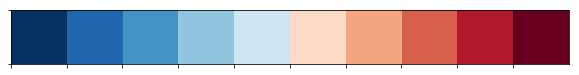

In [19]:
color_scale = np.array(['#053061','#2166ac','#4393c3','#92c5de','#d1e5f0','#fddbc7','#f4a582','#d6604d','#b2182b','#67001f'])
sns.palplot(sns.color_palette(color_scale))

In [28]:
def load_data(pollutant_ID):
    print('> Loading data...')
    date_vars = ['DatetimeBegin','DatetimeEnd']
    filename = 'BE_' + str(pollutant_ID) + '_2013-2015_aggregated_timeseries.csv'
    agg_ts = pd.read_csv(project_dir / filename, sep='\t', parse_dates=date_vars, date_parser=pd.to_datetime)
    return agg_ts

In [23]:
def clean_data(df):
    print('> Cleaning data...')
    df = df.loc[df.DataAggregationProcess=='P1D', :] 
    df = df.loc[df.UnitOfAirPollutionLevel!='count', :]
    ser_avail_days = df.groupby('SamplingPoint').nunique()['DatetimeBegin']
    df = df.loc[df.SamplingPoint.isin(ser_avail_days[ser_avail_days.values >= 1000].index), :]
    vars_to_drop = ['AirPollutant','AirPollutantCode','Countrycode','Namespace','TimeCoverage','Validity','Verification','AirQualityStation',
               'AirQualityStationEoICode','DataAggregationProcess','UnitOfAirPollutionLevel', 'DatetimeEnd', 'AirQualityNetwork',
               'DataCapture', 'DataCoverage']
    df.drop(columns=vars_to_drop, axis='columns', inplace=True)
    
    dates = list(pd.period_range(min(df.DatetimeBegin), max(df.DatetimeBegin), freq='D').values)
    samplingpoints = list(df.SamplingPoint.unique())
    new_idx = []
    for sp in samplingpoints:
        for d in dates:
            new_idx.append((sp, np.datetime64(d)))

    df.set_index(keys=['SamplingPoint', 'DatetimeBegin'], inplace=True)
    df.sort_index(inplace=True)
    df = df.reindex(new_idx)
    df['AirPollutionLevel'] = df.groupby(level=0).AirPollutionLevel.bfill().fillna(0)
    return df

In [24]:
def color_coding(poll, bin_edges):    
    idx = np.digitize(poll, bin_edges, right=True)
    return color_scale[idx]

def prepare_data(df, pollutant_ID):
    print('> Preparing data...')
    df = df.reset_index().merge(meta, how='inner', on='SamplingPoint').set_index('DatetimeBegin')
    df = df.loc[:, ['SamplingPoint','Latitude', 'Longitude', 'AirPollutionLevel']]
    df = df.groupby('SamplingPoint', group_keys=False).resample(rule='M').last().reset_index()
    df['color'] = df.AirPollutionLevel.apply(color_coding, bin_edges=pollutants[pollutant_ID]['bin_edges'])
    return df

In [25]:
def create_geojson_features(df):
    print('> Creating GeoJSON features...')
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['Longitude'],row['Latitude']]
            },
            'properties': {
                'time': row['DatetimeBegin'].date().__str__(),
                'style': {'color' : row['color']},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': row['color'],
                    'fillOpacity': 0.8,
                    'stroke': 'true',
                    'radius': 7
                }
            }
        }
        features.append(feature)
    return features

In [26]:
def make_map(features):
    print('> Making map...')
    coords_belgium=[50.5039, 4.4699]
    pollution_map = folium.Map(location=coords_belgium, control_scale=True, zoom_start=8)

    TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features}
        , period='P1M'
        , add_last_point=True
        , auto_play=False
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='YYYY/MM'
        , time_slider_drag_update=True
    ).add_to(pollution_map)
    print('> Done.')
    return pollution_map
def plot_pollutant(pollutant_ID):
    print('Mapping {} pollution in Belgium in 2013-2015'.format(pollutants[pollutant_ID]['name']))
    df = load_data(pollutant_ID)
    df = clean_data(df)
    df = prepare_data(df, pollutant_ID)
    features = create_geojson_features(df)
    return make_map(features), df

In [29]:
pollution_map, df = plot_pollutant(1)
pollution_map.save('../output/pollution_so2.html')
pollution_map

Mapping Sulphur dioxide pollution in Belgium in 2013-2015
> Loading data...
> Cleaning data...
> Preparing data...
> Creating GeoJSON features...
> Making map...
> Done.


FileNotFoundError: [Errno 2] No such file or directory: '../output/pollution_so2.html'